In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import geopandas as gpd

In [34]:
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('valid.csv')

In [123]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [43]:
train_df['centroid'] = list(zip(train_df.lon, train_df.lat))

In [125]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8526526 entries, 0 to 8526525
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   lon            float64
 2   lat            float64
 3   likescount     int64  
 4   commentscount  int64  
 5   symbols_cnt    int64  
 6   words_cnt      int64  
 7   hashtags_cnt   int64  
 8   mentions_cnt   int64  
 9   links_cnt      int64  
 10  emoji_cnt      int64  
 11  point          object 
 12  centroid       object 
dtypes: float64(2), int64(9), object(2)
memory usage: 845.7+ MB


In [6]:
train_df.memory_usage().sum() / 1024 ** 2

845.6791229248047

Memory consumption optimization

In [35]:
for col in train_df.columns:
    column_type = train_df[col].dtype

    if column_type == object:
        continue
    
    min = train_df[col].min()
    max = train_df[col].max()
    
    if "int" in str(column_type):
        if min > np.iinfo(np.int8).min and max < np.iinfo(np.int8).max:
            train_df[col] = train_df[col].astype(np.int8)
        elif min > np.iinfo(np.int16).min and max < np.iinfo(np.int16).max:
            train_df[col] = train_df[col].astype(np.int16)
        elif min > np.iinfo(np.int32).min and max < np.iinfo(np.int32).max:
            train_df[col] = train_df[col].astype(np.int32)
        else:
            train_df[col] = train_df[col].astype(np.int64)
        continue
    
    elif "float" in str(column_type):
        if min > np.finfo(np.float32).min and max < np.finfo(np.float32).max:
            train_df[col] = train_df[col].astype(np.float32)
        continue

In [8]:
train_df.memory_usage().sum() / 1024 ** 2

374.0504493713379

In [9]:
train_df.to_csv('train_opt.csv', index=False)

Convert timestamps to datetime

In [36]:
train_df['datetime'] = pd.to_datetime(train_df['timestamp'], unit="s")
train_df = train_df.drop('timestamp', axis=1)

In [37]:
val_df['datetime'] = pd.to_datetime(val_df['hour'], unit="s")
val_df = val_df.drop('hour', axis=1)

In [157]:
train_df

,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,centroid,datetime
0,30.329370,59.940487,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,"(30.32936978008534, 59.94048754777036)",2019-08-12 11:00:00
1,30.342844,59.869541,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,"(30.342844509347128, 59.8695422185115)",2019-08-12 00:00:00
2,30.322632,60.039333,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,"(30.322632415454446, 60.03933228251395)",2019-08-12 00:00:00
3,30.322632,59.938236,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,"(30.322632415454446, 59.93823764413683)",2019-08-12 00:00:00
4,30.309158,59.932613,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,"(30.30915768619265, 59.932612217166536)",2019-08-12 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8526521,30.324879,59.932613,48,0,15,2,0,0,0,1,0101000020E61000005DECCB372B533E40494A4ED65FF7...,"(30.324878203664746, 59.932612217166536)",2019-08-16 18:00:00
8526522,30.324879,59.932613,20,1,0,0,0,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...,"(30.324878203664746, 59.932612217166536)",2019-08-16 18:00:00
8526523,30.324879,59.932613,54,2,75,7,0,0,0,6,0101000020E61000005DECCB372B533E40494A4ED65FF7...,"(30.324878203664746, 59.932612217166536)",2019-08-16 18:00:00
8526524,30.324879,59.932613,15,0,350,4,25,0,0,0,0101000020E61000005DECCB372B533E40494A4ED65FF7...,"(30.324878203664746, 59.932612217166536)",2019-08-16 16:00:00


In [13]:
print(f'Number of unique points: {train_df.point.nunique()}')

Number of unique points: 7041


In [14]:
print(f'Number of unique points: {train_df.centroid.nunique()}')

Number of unique points: 7041


Points and centroids are the different representetion of the same

In [39]:
import folium
import osmnx as ox
from shapely import wkt

def visualize_polygons(geometry):
    
    lats, lons = get_lat_lon(geometry)
    
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=13, tiles='cartodbpositron')
    
    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name = 'boundary').add_to(m)
    
    return m

def get_lat_lon(geometry):
        
    lon = geometry.apply(lambda x: x.x if x.type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.type == 'Point' else x.centroid.y)
    return lat, lon

In [40]:
import pygeos
gpd.options.use_pygeos = True
USE_PYGEOS=1

In [62]:
cities = ['Санкт-Петербург']
polygon_krd = ox.geometries_from_place(cities, {'boundary':'administrative'}).reset_index()
polygon_krd = polygon_krd[(polygon_krd['name'] == 'Санкт-Петербург')]

visualize_polygons(polygon_krd['geometry'])

In [8]:
polygon_krd

,element_type,osmid,highway,geometry,ref,addr:country,addr:region,name,name:be,name:ca,...,old_name:mk,oktmo:user,contact:instagram,contact:vk,contact:website,oktmo,short_name:be,short_name:ru,short_name:uk,admin_centre
1246,relation,337422,NaN,"MULTIPOLYGON (((30.06506 59.66830, 30.07331 59...",RU-SPE,NaN,NaN,Санкт-Петербург,Санкт-Пецярбург,Sant Petersburg,...,Ленинград,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
with open('polygon.txt', 'w') as f:
    f.write(str(polygon_krd['geometry'][1246]))

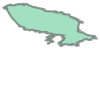

In [41]:
polygon = wkt.load(open("polygon.txt"))
polygon

In [44]:
# Appropriate form for shapely
train_df.centroid =  train_df.centroid.apply(lambda x: 'POINT ' +  str(x).replace(',', ' ')) 

In [45]:
unique_locations = train_df[["centroid"]].groupby(["centroid"]).first().reset_index()

In [46]:
unique_locations["in_spb"] = unique_locations["centroid"].apply(lambda x: polygon.contains(wkt.loads(x))).astype(int)

Innapropriate locations

In [132]:
unique_locations.loc[unique_locations['in_spb']==0]

,centroid,in_spb
0,POINT (-48.41021066120101 -1.3900065324650763),0
1,POINT (0.0 0.0),0
2,POINT (137.13681127368616 35.032142207354845),0
3,POINT (18.84665466082756 42.289870330403645),0
4,POINT (20.486080054345685 54.71500653820782),0
...,...,...
7036,POINT (37.81233609680096 55.70797485949529),0
7037,POINT (40.25126209318545 43.68939181898115),0
7038,POINT (41.021567449317935 42.99689995244231),0
7039,POINT (62.09828980297222 57.45166050067814),0


In [47]:
train_df = train_df.merge(
    unique_locations[["centroid", "in_spb"]], how="left", left_on="centroid", right_on="centroid"
)

Leave only places located in SPb

In [48]:
train_df = train_df[train_df["in_spb"] == 1]
train_df = train_df.drop(['in_spb'], axis=1)

In [49]:
train_df = train_df.drop('centroid', axis=1)

Time features

In [204]:
import holidays
import datetime

russian_holidays = holidays.RU()

# Special SPb days

class ScarletSails(holidays.HolidayBase):
    def _populate(self, year):
        self[datetime.date(2019, 6, 23)] = "Scarlet Sails"
        self[datetime.date(2020, 6, 27)] = "Scarlet Sails"

class CityDay(holidays.HolidayBase):
    def _populate(self, year):
        self[datetime.date(year, 5, 27)] = "City Day"
        
russian_holidays += ScarletSails()
russian_holidays += CityDay()

In [51]:
def time_features(df):
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["weekday"] = df["datetime"].dt.weekday
    df["hour"] = df["datetime"].dt.hour

    df["weekend"] = df["datetime"].dt.weekday // 5 
    df["holidays"] = df["datetime"].apply(
        lambda x: int(x in russian_holidays)
    )
    

In [186]:
time_features(train_df)

In [11]:
time_features(val_df)

In [41]:
train_df.to_csv('train_opt.csv', index=False)

Number of posts distribution

In [52]:
centroid_df =  train_df.groupby(["lon", 'lat']).first().reset_index()

In [ ]:
post_nums = []
for i in range(centroid_df.shape[0]):
    num = train_df.loc[(train_df['lon']==centroid_df.lon[i]) & (train_df['lat']==centroid_df.lat[i])]
    post_nums.append(num.shape[0])

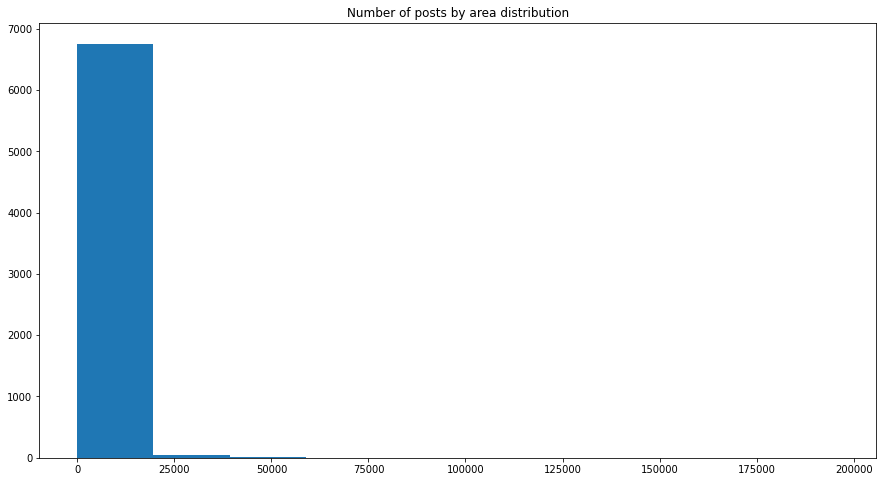

In [44]:
plt.figure(figsize=(15, 8))
plt.hist(post_nums)
plt.title("Number of posts by area distribution")
plt.show()

Show places with huge number of posts

In [73]:
popular_places['centroid'] = list(zip(popular_places.lat, popular_places.lon))

/tmp/ipykernel_64408/2091961160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_places['centroid'] = list(zip(popular_places.lat, popular_places.lon))


In [74]:
popular_places

,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,datetime,year,month,day,weekday,hour,weekend,holidays,centroid
485,30.199114,59.982082,75,0,0,0,0,0,0,0,2019-08-12 01:00:00,2019,8,12,0,1,0,0,"(59.98208236694336, 30.199113845825195)"
1224,30.241783,59.924736,106,6,253,25,1,0,0,0,2019-08-12 00:00:00,2019,8,12,0,0,0,0,"(59.92473602294922, 30.241783142089844)"
2299,30.288946,59.929237,34,0,0,0,0,0,0,0,2019-08-12 00:00:00,2019,8,12,0,0,0,0,"(59.929237365722656, 30.2889461517334)"
2535,30.300175,59.949486,58,0,42,6,0,0,0,2,2019-08-12 00:00:00,2019,8,12,0,0,0,0,"(59.949485778808594, 30.300174713134766)"
2684,30.306911,59.933739,3,0,51,3,0,0,0,0,2019-08-12 00:00:00,2019,8,12,0,0,0,0,"(59.933738708496094, 30.30691146850586)"
2859,30.313650,59.939362,15,3,0,0,0,0,0,0,2019-08-12 00:00:00,2019,8,12,0,0,0,0,"(59.939361572265625, 30.313650131225586)"
2924,30.315895,59.950611,11,0,19,2,0,0,0,2,2019-08-12 03:00:00,2019,8,12,0,3,0,0,"(59.95061111450195, 30.315895080566406)"


In [ ]:
import h3

def visualize_hexagons(hexagons, color="red", folium_map=None):

    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=20, tiles='cartodbpositron')
    else:
        m = folium_map
        
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=4,color=color)
        m.add_child(my_PolyLine)
    return m


h3_addresses  = []
for i in popular_places.centroid:
    h3_addresses.append(h3.geo_to_h3(i[0], i[1],  10) )
 
                                                                                               
visualize_hexagons(h3_addresses)

### Correlations

Create target column

In [60]:
train_df['sum'] = 1
train_df =  train_df.groupby(by=["datetime", "point", "lon", "lat"], as_index=False).sum()

In [62]:
time_features(train_df)

In [64]:
for col in train_df.columns:
    column_type = train_df[col].dtype

    if column_type == object:
        continue
    
    min = train_df[col].min()
    max = train_df[col].max()
    
    if "int" in str(column_type):
        if min > np.iinfo(np.int8).min and max < np.iinfo(np.int8).max:
            train_df[col] = train_df[col].astype(np.int8)
        elif min > np.iinfo(np.int16).min and max < np.iinfo(np.int16).max:
            train_df[col] = train_df[col].astype(np.int16)
        elif min > np.iinfo(np.int32).min and max < np.iinfo(np.int32).max:
            train_df[col] = train_df[col].astype(np.int32)
        else:
            train_df[col] = train_df[col].astype(np.int64)
        continue
    
    elif "float" in str(column_type):
        if min > np.finfo(np.float32).min and max < np.finfo(np.float32).max:
            train_df[col] = train_df[col].astype(np.float32)
        continue

/tmp/ipykernel_26477/2464565370.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.drop('datetime', axis=1).corr()


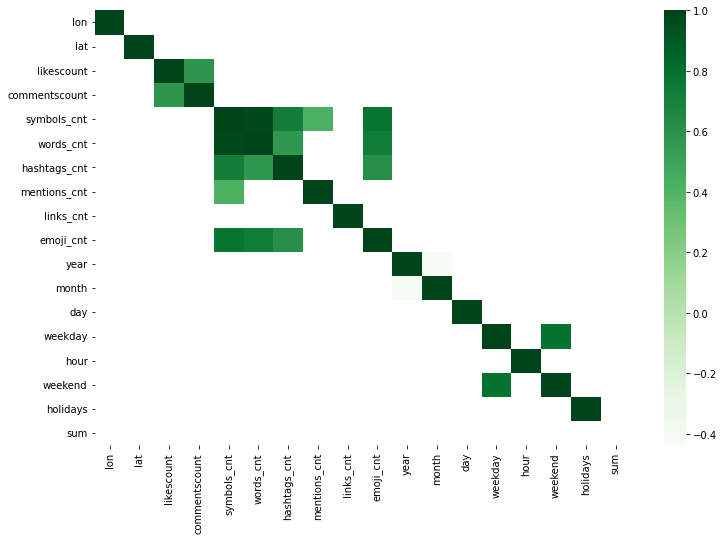

In [199]:
corr = train_df.drop('datetime', axis=1).corr()

kot = corr[corr.apply(abs)>=.4]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens");

In [116]:
train_df.loc[train_df['weekend']==1]['sum'].sum(), train_df.loc[train_df['weekend']==0]['sum'].sum()

(608390, 5725739)

Relation between total amount of posts in weekends and weekdays

In [121]:
608390/5725739

0.10625527988614221

In [144]:
train_df

,datetime,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,year,month,day,weekday,hour,weekend,holidays,sum
0,2019-01-01 00:00:00,30.136232,60.000053,104,2,56,1,4,0,0,1,2019,1,1,1,0,0,1,2
1,2019-01-01 00:00:00,30.138477,59.835705,96,1,138,7,9,0,0,4,2019,1,1,1,0,0,1,3
2,2019-01-01 00:00:00,30.142969,60.023628,233,10,104,8,2,0,0,5,2019,1,1,1,0,0,1,3
3,2019-01-01 00:00:00,30.142969,60.030357,19,3,0,0,0,0,0,0,2019,1,1,1,0,0,1,1
4,2019-01-01 00:00:00,30.142969,60.031479,97,2,56,5,0,0,0,17,2019,1,1,1,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552978,2020-01-31 23:00:00,30.470854,59.946110,21,2,0,0,0,0,0,0,2020,1,31,4,23,0,0,1
3552979,2020-01-31 23:00:00,30.473101,59.950611,41,1,22,3,0,0,0,1,2020,1,31,4,23,0,0,1
3552980,2020-01-31 23:00:00,30.484329,59.907848,269,65,3,0,0,0,0,3,2020,1,31,4,23,0,0,2
3552981,2020-01-31 23:00:00,30.500050,59.831192,51,1,260,26,1,0,0,1,2020,1,31,4,23,0,0,1


/tmp/ipykernel_73639/3323479399.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df.groupby(by=["hour"], as_index=False).sum()['sum'].plot.bar();


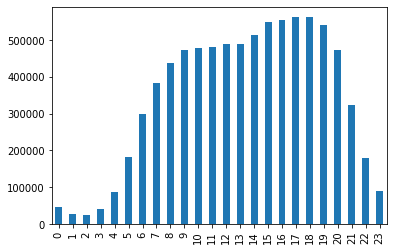

In [17]:
train_df.groupby(by=["hour"], as_index=False).sum()['sum'].plot.bar();

Features that include information of "emotional" and "talkable" users

In [65]:
train_df['centroid'] = list(zip(train_df.lon, train_df.lat))

In [66]:
centroid_df =  train_df[:]

In [67]:
centroid_df = centroid_df.groupby(["centroid"]).sum()

/tmp/ipykernel_36287/566605034.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroid_df = centroid_df.groupby(["centroid"]).sum()


In [218]:
centroid_df

,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,year,month,day,weekday,hour,weekend,holidays,sum
centroid,,,,,,,,,,,,,,,,,,
"(30.08907127380371, 59.85150146484375)",1414.186401,2813.020508,1312,55,11930,545,508,12,0,58,94896,270,748,132,610,10,0,47
"(30.08907127380371, 59.85262680053711)",30.089071,59.852627,61,1,0,0,0,0,0,0,2019,5,9,3,10,0,1,1
"(30.09131622314453, 59.83345031738281)",3851.688477,7658.681641,8922,338,32465,2469,634,5,7,283,258441,870,2218,400,1816,47,6,128
"(30.09131622314453, 59.85150146484375)",60.182632,119.703003,8,0,72,0,7,0,0,0,4038,20,39,4,34,0,0,2
"(30.09131622314453, 59.85262680053711)",1173.561279,2334.252441,8881,224,9640,867,58,2,0,135,78742,240,677,113,514,11,1,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(30.5539493560791, 59.83232116699219)",61.107899,119.664642,131,27,1003,77,13,8,1,0,4038,11,38,1,28,0,0,2
"(30.556194305419922, 59.83457565307617)",30.556194,59.834576,103,3,148,10,3,1,0,0,2019,5,15,2,13,0,0,1
"(30.574161529541016, 59.81877517700195)",1528.708130,2990.938721,3658,181,10405,718,270,3,0,138,100950,317,622,127,651,10,0,50


In [68]:
extra_cols = ['likescount', 'commentscount', 'symbols_cnt', 'words_cnt',
              'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']

In [69]:
def related_feature(df, col):
    df[col+'_rel'] = df[col] / df['sum']

In [70]:
for i in extra_cols:
    related_feature(centroid_df, i)

In [71]:
centroid_df.columns

Index(['lon', 'lat', 'likescount', 'commentscount', 'symbols_cnt', 'words_cnt',
       'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt', 'sum', 'year',
       'month', 'day', 'weekday', 'hour', 'weekend', 'holidays',
       'likescount_rel', 'commentscount_rel', 'symbols_cnt_rel',
       'words_cnt_rel', 'hashtags_cnt_rel', 'mentions_cnt_rel',
       'links_cnt_rel', 'emoji_cnt_rel'],
      dtype='object')

In [55]:
centroid_df

,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,...,holidays,sum,likescount_rel,commentscount_rel,symbols_cnt_rel,words_cnt_rel,hashtags_cnt_rel,mentions_cnt_rel,links_cnt_rel,emoji_cnt_rel
centroid,,,,,,,,,,,,,,,,,,,,,
"(30.08907127380371, 59.85150146484375)",1414.186401,2813.020508,1312,55,11930,545,508,12,0,58,...,0,52,25.230769,1.057692,229.423077,10.480769,9.769231,0.230769,0.000000,1.115385
"(30.08907127380371, 59.85262680053711)",30.089071,59.852627,61,1,0,0,0,0,0,0,...,1,1,61.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(30.09131622314453, 59.83345031738281)",3851.688477,7658.681641,8922,338,32465,2469,634,5,7,283,...,6,138,64.652174,2.449275,235.253623,17.891304,4.594203,0.036232,0.050725,2.050725
"(30.09131622314453, 59.85150146484375)",60.182632,119.703003,8,0,72,0,7,0,0,0,...,0,2,4.000000,0.000000,36.000000,0.000000,3.500000,0.000000,0.000000,0.000000
"(30.09131622314453, 59.85262680053711)",1173.561279,2334.252441,8881,224,9640,867,58,2,0,135,...,1,44,201.840909,5.090909,219.090909,19.704545,1.318182,0.045455,0.000000,3.068182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(30.5539493560791, 59.83232116699219)",61.107899,119.664642,131,27,1003,77,13,8,1,0,...,0,2,65.500000,13.500000,501.500000,38.500000,6.500000,4.000000,0.500000,0.000000
"(30.556194305419922, 59.83457565307617)",30.556194,59.834576,103,3,148,10,3,1,0,0,...,0,1,103.000000,3.000000,148.000000,10.000000,3.000000,1.000000,0.000000,0.000000
"(30.574161529541016, 59.81877517700195)",1528.708130,2990.938721,3658,181,10405,718,270,3,0,138,...,0,60,60.966667,3.016667,173.416667,11.966667,4.500000,0.050000,0.000000,2.300000


In [72]:
centroid_df['centroid'] = list(zip(centroid_df.lon, centroid_df.lat))

In [73]:
train_df = train_df.merge(
    centroid_df[['lon', 'lat', 'likescount_rel', 'commentscount_rel', 'symbols_cnt_rel',
       'words_cnt_rel', 'hashtags_cnt_rel', 'mentions_cnt_rel',
       'links_cnt_rel', 'emoji_cnt_rel']], how="left", left_on="centroid", right_on="centroid"
)

In [74]:
train_df = train_df.drop('centroid', axis=1)

In [75]:
train_df = train_df.drop(['likescount', 'commentscount', 'symbols_cnt', 'words_cnt',
       'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt'], axis=1)

In [76]:
train_df = train_df.drop(['lon_y', 'lat_y'], axis=1)

In [77]:
train_df

,datetime,point,lon_x,lat_x,sum,year,month,day,weekday,hour,weekend,holidays,likescount_rel,commentscount_rel,symbols_cnt_rel,words_cnt_rel,hashtags_cnt_rel,mentions_cnt_rel,links_cnt_rel,emoji_cnt_rel
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,30.248522,60.018017,1,2019,1,1,1,0,0,1,59.404840,3.564639,373.604317,28.918029,5.220842,0.164596,0.022019,4.135819
1,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E40586790FFD8EC...,30.248522,59.850372,1,2019,1,1,1,0,0,1,41.962779,1.833747,164.925558,9.622829,4.942928,0.126551,0.027295,2.421836
2,2019-01-01 00:00:00,0101000020E61000000614FD60523D3E400086058A8CFB...,30.239538,59.965225,1,2019,1,1,1,0,0,1,129.417342,7.149170,341.682384,24.967205,6.559193,0.337449,0.024694,4.608190
3,2019-01-01 00:00:00,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,30.239538,59.858269,2,2019,1,1,1,0,0,1,57.065574,2.024590,200.221311,13.172131,4.918033,0.163934,0.016393,2.172131
4,2019-01-01 00:00:00,0101000020E61000000614FD60523D3E40D800D455BF04...,30.239538,60.037090,1,2019,1,1,1,0,0,1,38.517241,10.103448,294.379310,23.206897,3.448276,0.137931,0.000000,3.586207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552978,2020-01-31 23:00:00,0101000020E6100000F26A77FAD1483E407916A554F5F8...,30.284454,59.944988,1,2020,1,31,4,23,0,0,92.969334,4.980261,226.185407,17.469158,3.880860,0.175185,0.006697,2.680296
3552979,2020-01-31 23:00:00,0101000020E6100000F5A5CFA399243E40854A58CAE203...,30.142969,60.030357,1,2020,1,31,4,23,0,0,36.532506,2.933682,267.174779,18.605031,4.787978,0.179026,0.002940,3.027769
3552980,2020-01-31 23:00:00,0101000020E6100000F5BF2B4285463E401AD725FD56F3...,30.275471,59.901093,2,2020,1,31,4,23,0,0,59.151287,2.489731,265.936535,18.987677,5.652068,0.165693,0.015968,2.674053
3552981,2020-01-31 23:00:00,0101000020E6100000F914E08938443E407916A554F5F8...,30.266487,59.944988,1,2020,1,31,4,23,0,0,86.603125,3.964963,289.388627,22.128550,5.081111,0.340258,0.019534,1.871016


In [78]:
train_df.to_csv('train_preprocessed.csv', index=False)

## Model training

### FEDOT
Regression

In [79]:
from fedot.api.main import Fedot

In [80]:
model = Fedot(problem='regression', timeout=5, preset='best_quality', n_jobs=-1, logging_level=20)
model.fit(features=train_df.drop(['sum', 'datetime', 'point'], axis=1), target=train_df['sum'])

2022-11-19 09:39:35,121 - AssumptionsHandler - Initial pipeline fitting started
2022-11-19 10:16:31,899 - fedot.core.caching.base_cache - Nodes can not be saved: BLOB longer than INT_MAX bytes. Continue
2022-11-19 10:17:31,305 - AssumptionsHandler - Initial pipeline was fitted successfully
2022-11-19 10:17:32,807 - ApiComposer - Initial pipeline was fitted in 2280.2 sec.
2022-11-19 10:17:32,814 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['isolation_forest_reg', 'knnreg', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'svr', 'lgbmreg', 'lasso', 'dtreg', 'scaling', 'ransac_non_lin_reg', 'rfr', 'normalization', 'gbr', 'linear', 'adareg', 'pca', 'sgdr', 'treg', 'ridge']
2022-11-19 10:17:48,077 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 2280.170008 sec.
2022-11-19 10:17:48,078 - DataSourceSplitter - K-folds cross validation is applied.
2022-11-19 10:17:48,079 - ApiComposer - Time for pipeli

{'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}

Prepare validation dataset

In [14]:
val_df = val_df.merge(
    train_df.groupby('point').first()[[ 'likescount_rel', 'commentscount_rel', 'symbols_cnt_rel',
       'words_cnt_rel', 'hashtags_cnt_rel', 'mentions_cnt_rel',
       'links_cnt_rel', 'emoji_cnt_rel']], how="left",on=['point','point'],
)

In [17]:
for_val_df = val_df[:]

In [19]:
for_val_df['lat_x'] = for_val_df['lat']
for_val_df['lon_x'] = for_val_df['lon']
for_val_df = for_val_df.drop(['lat', 'lon', 'error'], axis=1)

/tmp/ipykernel_36287/1768077638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_val_df['lat_x'] = for_val_df['lat']
/tmp/ipykernel_36287/1768077638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_val_df['lon_x'] = for_val_df['lon']


In [82]:
prediction = model.predict(features=for_val_df.drop(['sum', 'datetime', 'point'], axis=1))

In [87]:
def get_metric(true, pred):
    results = []
    for i in range(len(true)):
        error = abs(pred[i] - true[i]) / pred[i]
        results.append(error)
    return results

In [97]:
res = get_metric(val_df['sum'], prediction)

In [98]:
np.mean(res)

3.055399517273822

In [99]:
np.mean(val_df['error'])

2.5964150416355753

In [100]:
test_df = pd.read_csv('test.csv')

Feature values

In [108]:
import eli5
from sklearn.ensemble import RandomForestRegressor
from eli5.sklearn import PermutationImportance

In [111]:
rfr_mod = RandomForestRegressor(max_depth=2).fit(train_df.drop(['sum', 'datetime', 'point'], axis=1), train_df['sum'])

In [119]:
feat_val = PermutationImportance(rfr_mod, random_state=42).fit(for_val_df.drop(['sum', 'datetime', 'point'], axis=1),
                                                             for_val_df['sum'])
eli5.show_weights(feat_val, feature_names=for_val_df.drop(['sum', 'datetime', 'point'], axis=1).columns.tolist())

/home/ismirnov/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/ismirnov/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/ismirnov/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/ismirnov/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature

Weight,Feature
0.0027 ± 0.0200,symbols_cnt_rel
0 ± 0.0000,lon_x
0 ± 0.0000,likescount_rel
0 ± 0.0000,month
0 ± 0.0000,day
0 ± 0.0000,weekday
0 ± 0.0000,hour
0 ± 0.0000,weekend
0 ± 0.0000,holidays
0 ± 0.0000,commentscount_rel


### LightGBM

In [120]:
from lightgbm import LGBMRegressor

In [148]:
%%time

model_lgbm = LGBMRegressor(random_seed=42).fit(train_df.drop(['sum', 'datetime', 'point'], axis=1), train_df['sum'])

CPU times: user 5min 14s, sys: 1.63 s, total: 5min 16s
Wall time: 5.49 s


In [149]:
lgbm_preds = model_lgbm.predict(for_val_df.drop(['sum', 'datetime', 'point'], axis=1))

In [150]:
res_lgbm = get_metric(val_df['sum'], lgbm_preds)

In [151]:
np.mean(res_lgbm)

4.275775887072693

Another features

In [129]:
model_lgbm_2 = LGBMRegressor(random_seed=42).fit(train_df[['lon_x', 'lat_x', 'sum', 'year', 'month', 'day',
       'weekday', 'hour', 'weekend', 'holidays']], train_df['sum'])

In [154]:
lgbm_preds = model_lgbm_2.predict(for_val_df[['lon_x', 'lat_x', 'sum', 'year', 'month', 'day',
       'weekday', 'hour', 'weekend', 'holidays']])

In [131]:
res_lgbm = get_metric(val_df['sum'], lgbm_preds)

In [132]:
np.mean(res_lgbm)

4.318043223303311e-05

In [139]:
lgbm_preds

array([ 4.99980121, 13.99928635,  4.99980121,  6.99966261, 13.99928635,
        6.99966261, 12.99959898,  8.99960672, 30.99754176,  5.99974574,
        6.99966261, 14.99958852, 27.99879271,  6.99966261,  8.99960672,
       10.99951714,  5.99974574, 15.99920681,  6.99966261,  4.99980121,
        7.99969087,  4.99980121,  4.99980121,  8.99960672,  4.99980121,
        4.99980121,  5.99974574,  4.99980121,  4.99980121,  6.99966261,
        4.99980121,  5.99974574,  9.9996189 ,  4.99980121, 11.99943426,
        5.99974574,  7.99969087,  4.99980121, 19.99932645,  8.99960672,
       14.99958852,  8.99960672,  8.99960672,  6.99966261,  8.99960672,
        5.99974574, 10.99951714,  5.99974574, 22.99887666, 16.99943493,
        4.99980121, 10.99951714,  5.99974574,  4.99980121, 15.99920681,
        4.99980121,  4.99980121,  4.99980121,  5.99974574,  4.99980121,
       20.99959463,  4.99980121,  4.99980121, 16.99943493,  8.99960672,
       20.99959463,  4.99980121,  5.99974574,  5.99974574,  5.99

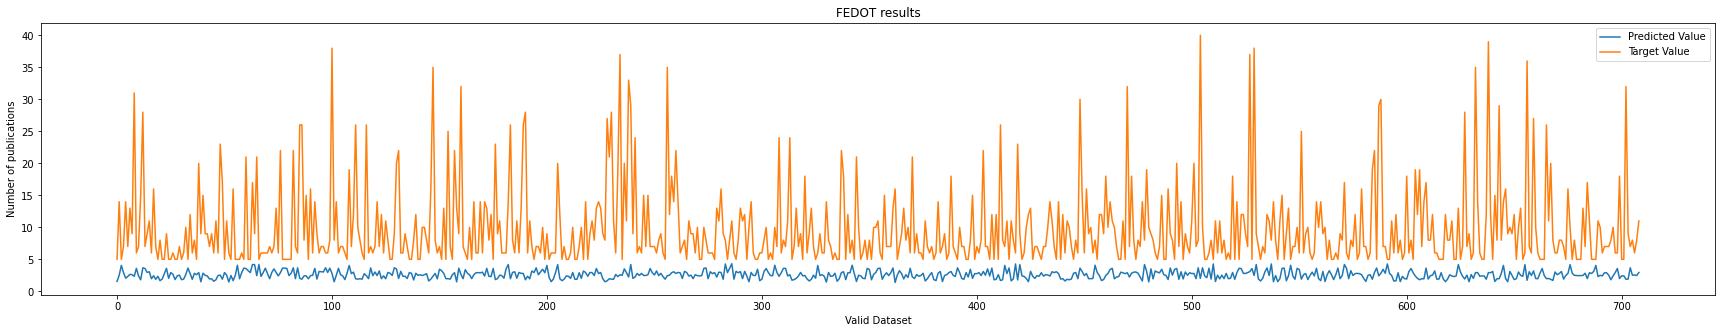

In [143]:
plt.figure(figsize=(30, 5))
plt.title('FEDOT results')
plt.plot(prediction, label="Predicted Value")
plt.plot(for_val_df['sum'], label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(30, 5))
plt.title('LightGBM results on val data')
plt.plot(lgbm_preds, label="Predicted Value")
plt.plot(for_val_df['sum'], label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

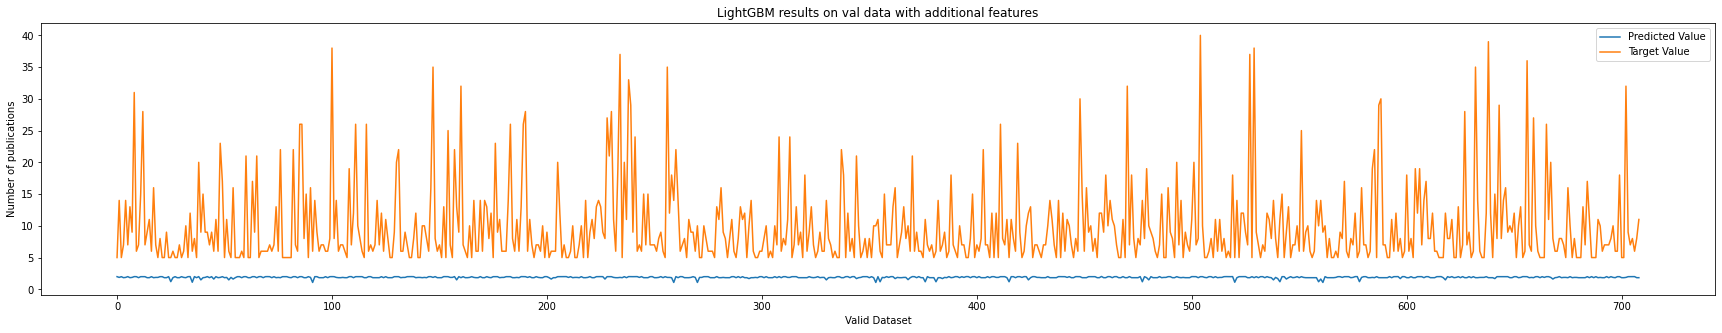

In [153]:
plt.figure(figsize=(30, 5))
plt.title('LightGBM results on val data with additional features')
plt.plot(lgbm_preds, label="Predicted Value")
plt.plot(for_val_df['sum'], label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

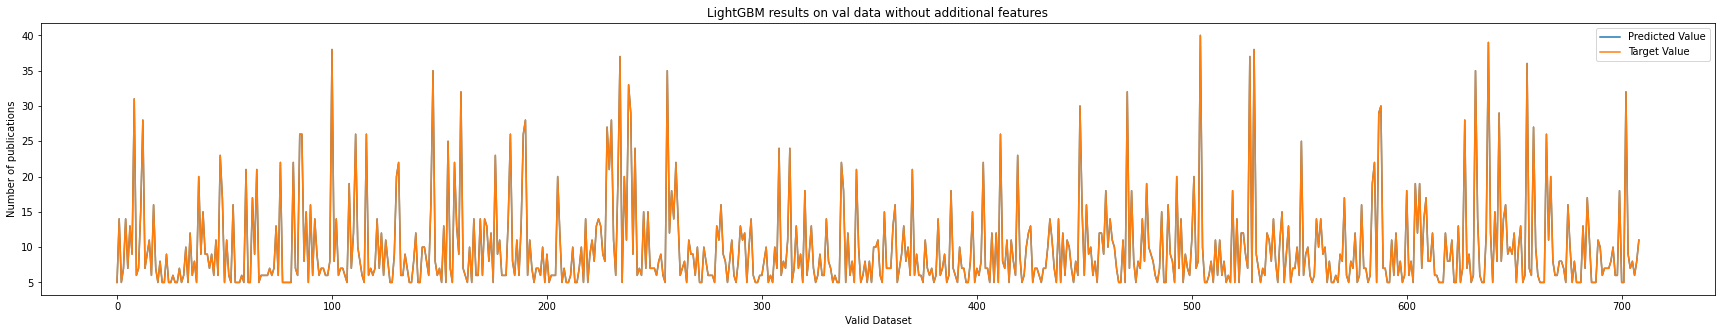

In [155]:
plt.figure(figsize=(30, 5))
plt.title('LightGBM results on val data without additional features')
plt.plot(lgbm_preds, label="Predicted Value")
plt.plot(for_val_df['sum'], label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

Test dataset

In [162]:
test_df

,lat,lon,point,sum,error,datetime,year,month,day,weekday,hour,weekend,holidays
0,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00,2020,2,26,2,10,0,0
1,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00,2020,2,17,0,11,0,0
2,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00,2020,2,12,2,16,0,0
3,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00,2020,2,12,2,13,0,0
4,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00,2020,2,15,5,13,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,2020-02-18 21:00:00,2020,2,18,1,21,0,0
696,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,2020-02-18 15:00:00,2020,2,18,1,15,0,0
697,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,2020-02-17 08:00:00,2020,2,17,0,8,0,0
698,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,2020-02-19 08:00:00,2020,2,19,2,8,0,0


In [167]:
test_preds = model_lgbm_2.predict(test_df[['lon_x', 'lat_x', 'sum', 'year', 'month', 'day',
       'weekday', 'hour', 'weekend', 'holidays']])

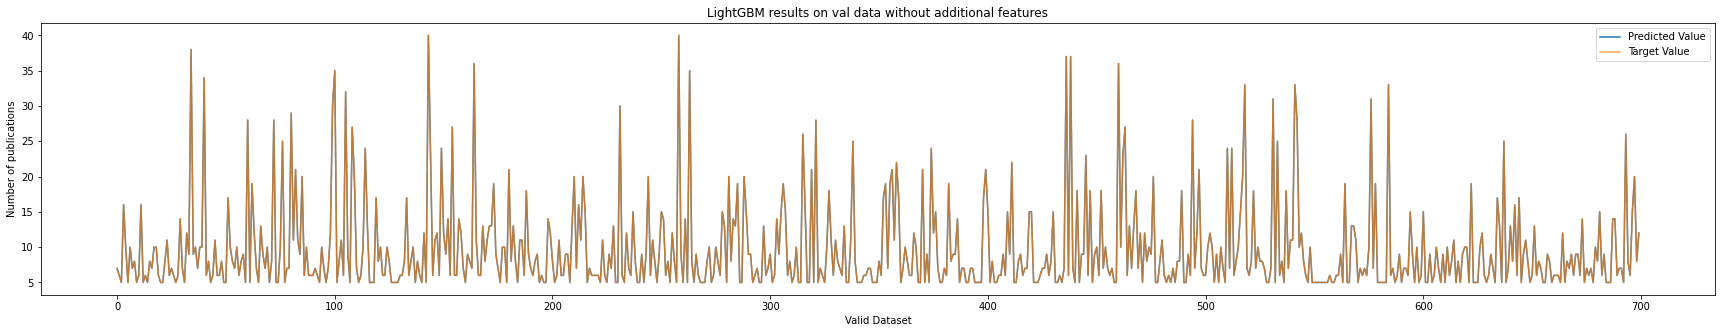

In [173]:
plt.figure(figsize=(30, 5))
plt.title('LightGBM results on val data without additional features')
plt.plot(test_preds, label="Predicted Value")
plt.plot(test_df['sum'], label="Target Value", alpha=0.7)
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

In [217]:
np.min(test_preds)

4.9998012085353

In [195]:
max_ind = 0
for ind in range(len(test_preds)):
    if test_preds[ind] == np.max(test_preds):
        max_ind = ind

In [196]:
max_ind

143

In [213]:
test_df.iloc[max_ind]

point       0101000020E6100000A4566D514B503E4006FC5DE561F8...
sum                                                        40
error                                               38.754735
datetime                                  2020-02-15 14:00:00
year                                                     2020
month                                                       2
day                                                        15
weekday                                                     5
hour                                                       14
weekend                                                     1
holidays                                                    0
lat_x                                               59.940488
lon_x                                               30.313649
Name: 143, dtype: object

In [210]:
h3_addresses  = []

h3_addresses.append(h3.geo_to_h3(59.940488, 30.313649,  10) )
                                                                       
visualize_hexagons(h3_addresses)
 

In [211]:
min_ind = 0
for ind in range(len(test_preds)):
    if test_preds[ind] == np.min(test_preds):
        min_ind = ind

In [214]:
test_df.iloc[min_ind]

point       0101000020E61000009E01B90998523E40888919D70805...
sum                                                         5
error                                                3.754735
datetime                                  2020-02-09 09:00:00
year                                                     2020
month                                                       2
day                                                         9
weekday                                                     6
hour                                                        9
weekend                                                     1
holidays                                                    0
lat_x                                               60.039332
lon_x                                               30.322632
Name: 692, dtype: object

In [215]:
h3_addresses  = []

h3_addresses.append(h3.geo_to_h3(60.039332, 30.322632,  10) )
                                                                       
visualize_hexagons(h3_addresses)